In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
from datetime import date, timedelta
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import time

#### Figure aesthetics

In [2]:
#print(plt.style.available)
#plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

#### Prepare dataset

In [3]:
## prepare dataset
confirmed = pd.read_csv("confirmed_man_cor.csv")
deaths = pd.read_csv("deaths_man_cor.csv")
recovered = pd.read_csv("recovered_man_cor.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

In [4]:
inactive=deaths.add(recovered)
data=confirmed.subtract(inactive)

#romeve for blog
data=confirmed

data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'])

#### List of countries in dataset

In [5]:
for el in data.columns:
    print(el)

Date
Poland


#### Get populations for countries in dataset

In [6]:
#data from: https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population 
#Was manually saved to csv. 
population_df=pd.read_csv("countries_population.csv",  encoding = "ISO-8859-1", header=None, usecols=[1,2], names=["country_name", "population"])
population_df

population_df['population'] = population_df['population'].apply(lambda x: str(x).replace(",", ""))
population_df['population'] = pd.to_numeric(population_df['population'], errors="coerce")

In [7]:
dictionary_country_names={
"US":"United States",
"Congo (Kinshasa)":"Congo",
"Cote d'Ivoire":"Ivory Coast",
"Czechia":"Czech Republic",
"French Guiana":"Guyana",
"Korea, South":"South Korea",
}

countries_populations = {}

for data_country_name in data.columns[1:]:
    searchfor=[data_country_name]
    try:
        searchfor.append(dictionary_country_names[data_country_name])
    except:
        pass
    
    check_names=0
    if check_names==1:
        if len(population_df[population_df["country_name"].str.contains('|'.join(searchfor))]) != 1:
            print(" ")   
            print(data_country_name)
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))] )
            print(population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum() )
            print(" ")
    countries_populations[data_country_name]=population_df[population_df['country_name'].str.contains('|'.join(searchfor))]["population"].sum()

#### Choose country to plot 

In [8]:
country_to_plot="Poland"
considered_countries={"predict":country_to_plot,}

In [9]:
fit_variants={
#"epidemia zacznie zwalniać po 2 dniach":2.0,
"spowolnienie +6 dni od 25.03":6.0,
"spowolnienie +12 dni od 25.03":12.0,
}

#### Dates to num

In [10]:
##extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
dates_num_org = mdates.date2num(dates)
dates_start = np.min(dates_num_org)
dates_num = dates_num_org - dates_start

date_epidemic_threat = datetime.date(2020, 3, 13)
#date_shutdown is a date from which days to inflection point of sigmoids are calculated
date_shutdown = datetime.date(2020, 3, 25)

end_hist_exp = int(mdates.date2num(date_shutdown)-dates_start)
print(end_hist_exp)
print(mdates.num2date(end_hist_exp+dates_start))

yesterday = date.today() - timedelta(days=1)
end_exp_yesterday = int(mdates.date2num(yesterday)-dates_start)

#value for blog
last_day_to_extrapolate = datetime.date(2020, 6, 30)

today=mdates.date2num(date.today())
days_to_extrapolate = mdates.date2num(last_day_to_extrapolate)
days_to_extrapolate=days_to_extrapolate-today

63
2020-03-25 00:00:00+00:00


#### Fit
Fits are performed on data normalized by country population. 

Currently as number of cases per 100 000 people.

Later for plotting data is "uunormalized"

In [11]:
#num days to extrapolate

dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

#for d1, d2 in zip(dates_num[:51], dates_num_extrapolate[:51]):
#    print(d1, d2)

#num iterations
maxit=100000
#for normalization
per_num=100000

def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

def sigmoid(x, L , k, b, x0):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

def sub_exponent(x, r, p, A):
#   y = (r*(1-p)*(x-x0) + A)**(1/(1-p))
    y = (r*(1-p)*x + A)**(1/(1-p))
    return y

def generalised_sigmoid(x, K, C, B, mi, x0):
    y = K / (C + np.exp(-B*(x-x0)))**(1/mi)
    #penalization = abs(1.0 - C)*1000000
    #penalization2 = abs(2 - (C + np.exp(-B*(77-x0)))**(1/mi))*100
    #return y + penalization + penalization2
    return y




#def generalised_sigmoid(t, Au, Al, A, m, k, mu):
#     B = (1-((Au-Al)/(A-Al))**(1/m))
#    y = Al + (A - Al)*(1-(1-((Au-Al)/(A-Al))**(1/m))*np.exp(-k*(t-mu)))**m
#    #half = mu + 1/k*np.log10(m*(1-((Au-Al)/(A-Al))**(1/m)))
#    #penalization = abs(69.0 - half)*10
#    return y


#fit free exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
pred_exp_popt, pred_exp_pcov = curve_fit(exponent, dates_num, pred_data, maxfev=maxit)
print(pred_exp_popt)
pred_exp_fit = exponent(dates_num_extrapolate, *pred_exp_popt)

#fit historical exponent to data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
hist_exp_popt, hist_exp_pcov = curve_fit(exponent, dates_num[:end_hist_exp+1], pred_data[:end_hist_exp+1], maxfev=maxit)
print(hist_exp_popt)
hist_exp_fit = exponent(dates_num_extrapolate, *hist_exp_popt)


#fit sub exponent to the data
pred_data=(data[considered_countries["predict"]].values/countries_populations[considered_countries["predict"]])*per_num
skip_initial_days=int(1)
(subexp_start)=np.min(np.nonzero(pred_data))+skip_initial_days
subexp_pred_data = pred_data[subexp_start:]
subexp_dates_num=dates_num[subexp_start:]
#subexp_dates_num_extrapolate=dates_num_extrapolate[subexp_start:]
subexp_dates_num_extrapolate=dates_num_extrapolate[0:]

sub_exp_popt, sub_exp_pcov = curve_fit(sub_exponent, subexp_dates_num, subexp_pred_data, 
                                       maxfev=maxit*10000, 
                                       p0=[0.3,0.9,5.0],
                                        #method="dogbox",
                                      )
sub_exp_fit=sub_exponent(subexp_dates_num_extrapolate, *sub_exp_popt)
sub_exp_fit = np.nan_to_num(sub_exp_fit, nan=0.0)
print(sub_exp_fit)

print("sub exponent")
print(sub_exp_popt)


##fit unfixed sigmoid to data
pred_sig_popt, pred_sig_pcov = curve_fit(sigmoid, dates_num, pred_data, p0=[np.max(pred_data),1,1,1], maxfev=maxit)
print("unfixed sigmoid")
print(pred_sig_popt)
pred_sig_fit = sigmoid(dates_num_extrapolate, *pred_sig_popt)

##fit sigmoid with given x for half value to data
pred_sig_popt_fixed={}
pred_sig_pcov_fixed={}
pred_sig_fit_fixed={}

for variant_name, variant_value in zip(fit_variants, fit_variants.values()):
    print(variant_name, variant_value)
    
    x0 = int((mdates.date2num(date_shutdown)-dates_start) + variant_value)
    print (x0)
    fixed_sigmoid = lambda x, L , k, b: sigmoid(x, L , k, b, x0)

    pred_sig_popt_fixed[variant_name], pred_sig_pcov_fixed[variant_name] = curve_fit(fixed_sigmoid , dates_num[:x0+1], pred_data[:x0+1], p0=pred_sig_popt[:-1])
    pred_sig_fit_fixed[variant_name] = fixed_sigmoid(dates_num_extrapolate, *pred_sig_popt_fixed[variant_name])
    
    print(pred_sig_popt_fixed[variant_name])
    

##fit unfixed general sigmoid to data
gen_sig_popt, gen_sig_pcov = curve_fit(generalised_sigmoid, dates_num, pred_data, maxfev=maxit*1000)
print("Unfixed genera sigmoid")
print(gen_sig_popt)
gen_sig_fit = generalised_sigmoid(dates_num_extrapolate, *gen_sig_popt)


gen_sig_popt_fixed={}
gen_sig_pcov_fixed={}
gen_sig_fit_fixed={}


for variant_name, variant_value in zip(fit_variants, fit_variants.values()):
#    print(variant_name, variant_value)

    x0 = int((mdates.date2num(date_shutdown)-dates_start) + variant_value)
    
#    fixed_general_sigmoid = lambda x, K, C, B, mi,: generalised_sigmoid(x, K, C, B, mi, x0)
    
    print (x0)
#    gen_sig_popt_fixed[variant_name], gen_sig_pcov_fixed[variant_name] = curve_fit(fixed_general_sigmoid , dates_num[:x0+1], pred_data[:x0+1], p0=gen_sig_popt[:-1], maxfev=maxit)
#    gen_sig_fit_fixed[variant_name] = fixed_general_sigmoid(dates_num_extrapolate, *gen_sig_popt_fixed[variant_name])
#    print(gen_sig_popt_fixed[variant_name])



[0.00818969 0.09725851 1.62109347]
[6.78013932e-05 1.99466416e-01 9.61053323e+00]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.06227944e-18
 6.74966688e-04 4.69828483e-03 1.46171680e-02 3.27038309e-02
 6.10765653e-02 1.01747392e-01 1.56647914e-01 2.27645494e-01
 3.16554287e-01 4.25143226e-01 5.55142038e-01 7.08245945e-01
 8.86119414e-01 1.09039923e+00 1.32269703e+00 1.58460148e+00
 1.

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in power
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in exp
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


#### Make plots

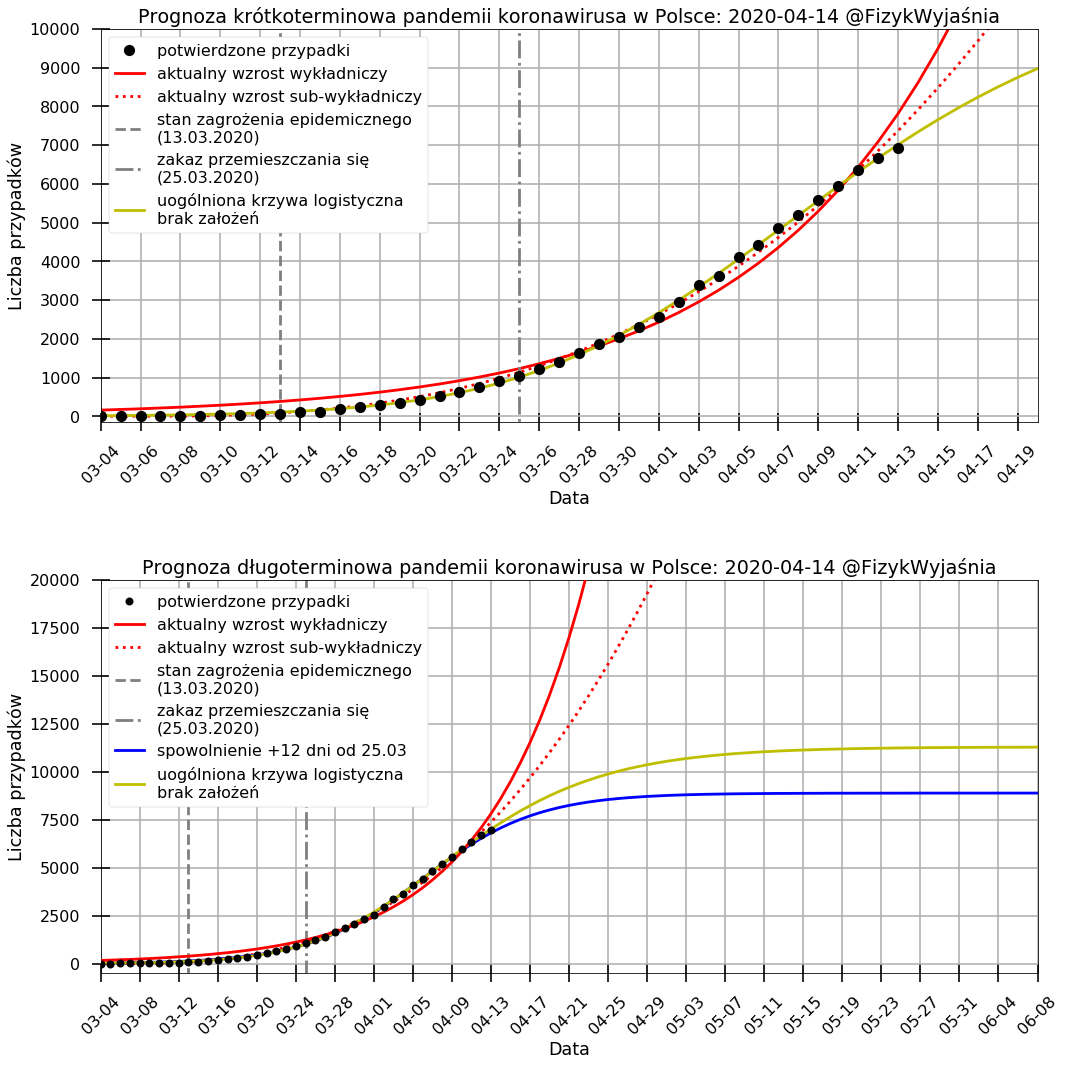

In [27]:
## Create figure and plot space
fig, (ax, ax2) = plt.subplots(2,1, figsize=(16, 16), )

marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k','mediumorchid','r', 'darkorange', 'g', 'b', 'y','c','m'))

short_prognosis_title = "Prognoza krótkoterminowa pandemii koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
long_prognosis_title = "Prognoza długoterminowa pandemii koronawirusa w Polsce: "+time.strftime("%Y-%m-%d")+" @FizykWyjaśnia"
x_label = "Data"
y_label = "Liczba przypadków"
date_epidemic_threat_label="stan zagrożenia epidemicznego \n(13.03.2020)"
shutdown_label="zakaz przemieszczania się \n(25.03.2020)"
label_MZ_data="potwierdzone przypadki"


## Absolute values
unnorm=countries_populations[considered_countries["predict"]]/per_num


## Short term prognosis
col=next(color)
ax.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label=label_MZ_data, color=col, zorder=10)
col=next(color)
#hist_exp_fit
#ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), hist_exp_fit*unnorm, color=col, label="brak działań (wzrost wykładniczy)")
col=next(color)
ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="aktualny wzrost wykładniczy")
#col=next(color)
ax.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color=col, label="aktualny wzrost sub-wykładniczy", linestyle="dotted")
#one sigmoid in short-term
#variant_name="spowolnienie +12 dni od 25.03"
#col="blue"    
#ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit_fixed[variant_name]*unnorm, color=col, label=variant_name)
ax.axvline(date_epidemic_threat, -10, 10000000, label=date_epidemic_threat_label, linestyle='--', color='gray', )
ax.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='-.', color='gray', )

ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), gen_sig_fit*unnorm, color='y', label="uogólniona krzywa logistyczna \nbrak założeń")
    
ax.set(xlabel=x_label,
       ylabel=y_label,
       title=short_prognosis_title)

##
#Long term prognosis
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('k', 'r', 'g', 'b', 'y','c','darkorange'))

col=next(color)
ax2.plot(dates, pred_data*unnorm, marker=next(marker), linestyle='', label=label_MZ_data, color=col, zorder=10, markersize=8)
col=next(color)
ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_exp_fit*unnorm, color=col, label="aktualny wzrost wykładniczy", zorder=9)
ax2.plot(mdates.num2date(subexp_dates_num_extrapolate+dates_start), sub_exp_fit*unnorm, color=col, label="aktualny wzrost sub-wykładniczy", linestyle="dotted")
ax2.axvline(date_epidemic_threat, -10, 10000000, label=date_epidemic_threat_label, linestyle='--', color='gray', )
ax2.axvline(date_shutdown, -10, 10000000, label=shutdown_label, linestyle='-.', color='gray', )

for variant_name in fit_variants:
    col=next(color)
    if variant_name != "spowolnienie +6 dni od 25.03":
        ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), pred_sig_fit_fixed[variant_name]*unnorm, color=col, label=variant_name)

col=next(color)
ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), gen_sig_fit*unnorm, color=col, label="uogólniona krzywa logistyczna \nbrak założeń")

ax2.set(xlabel=x_label,
       ylabel=y_label,
       title=long_prognosis_title)

## adjusting parameters on both plots
for axis in [ax, ax2]:
    ## Define the date format
    date_form = DateFormatter("%m-%d")
    axis.xaxis.set_major_formatter(date_form)
    axis.xaxis.set_tick_params(rotation=45, direction="out")
    axis.tick_params(direction='inout', length=18, colors='k')

    
    legend = axis.legend(frameon=1, facecolor='white', framealpha=1, fontsize=16, handlelength=1.8)#, loc='upper left')
    axis.grid(True)
    
    maxy_multip=1.1

#short term
axis = ax
tick_spacing=2
axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axis.set_xlim([datetime.date(2020, 3, 4), datetime.date(2020, 4, 20)])
axis.yaxis.set_major_locator(plt.MaxNLocator(12))
axis.set_ylim(-150,10000)
#axis.set_ylim(3000,4000)


#Long term
axis = ax2
axis.set_xlim([datetime.date(2020, 3, 4), datetime.date(2020, 6, 8)])
#axis.set_xlim([datetime.date(2020, 4, 1), datetime.date(2020, 4, 20)])

tick_spacing=4
axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
axis.set_ylim(-500,20000)
#axis.set_ylim(5000,7500)

        
        
##    legend = axis.legend(frameon=1, facecolor='white', framealpha=1)#, loc='upper left')
##    axis.grid(True)
    #axis.set_yscale("log")

#    frame = legend.get_frame()
#    frame.set_facecolor('green')
#    frame.set_edgecolor('red')
#    frame.set_alpha(1)


fig.tight_layout(pad=5.0) 
plt.show()

timestamp=time.strftime("%Y_%m_%d")

fig.savefig("./predictions_for_poland_figures/prognoza_"+timestamp+".png")

#print(mdates.num2date(dates_num_extrapolate[:51+1]+dates_start)[-1])


In [13]:
#Exponent predictions
for day, exp_value in zip(mdates.num2date(dates_num_extrapolate+dates_start),(pred_exp_fit*unnorm)):
    print(day, exp_value)

2020-01-22 00:00:00+00:00 2.685141900789444
2020-01-23 00:00:00+00:00 2.9594163854215596
2020-01-24 00:00:00+00:00 3.2617067052309885
2020-01-25 00:00:00+00:00 3.594874544642129
2020-01-26 00:00:00+00:00 3.962073895543826
2020-01-27 00:00:00+00:00 4.366780915107727
2020-01-28 00:00:00+00:00 4.812826833440908
2020-01-29 00:00:00+00:00 5.3044342225988235
2020-01-30 00:00:00+00:00 5.846256970305569
2020-01-31 00:00:00+00:00 6.4434243367996995
2020-02-01 00:00:00+00:00 7.1015895118774806
2020-02-02 00:00:00+00:00 7.826983131807353
2020-02-03 00:00:00+00:00 8.626472262742881
2020-02-04 00:00:00+00:00 9.507625409011027
2020-02-05 00:00:00+00:00 10.478784161688132
2020-02-06 00:00:00+00:00 11.549142165737454
2020-02-07 00:00:00+00:00 12.728832153264511
2020-02-08 00:00:00+00:00 14.029021866805872
2020-02-09 00:00:00+00:00 15.462019780726022
2020-02-10 00:00:00+00:00 17.041391621552524
2020-02-11 00:00:00+00:00 18.782088790309675
2020-02-12 00:00:00+00:00 20.700589902583207
2020-02-13 00:00:00

2020-01-22 00:00:00+00:00 0.0 0.0 nan
2020-01-23 00:00:00+00:00 0.0 0.0 nan
2020-01-24 00:00:00+00:00 0.0 0.0 nan
2020-01-25 00:00:00+00:00 0.0 0.0 nan
2020-01-26 00:00:00+00:00 0.0 0.0 nan
2020-01-27 00:00:00+00:00 0.0 0.0 nan
2020-01-28 00:00:00+00:00 0.0 0.0 nan
2020-01-29 00:00:00+00:00 0.0 0.0 nan
2020-01-30 00:00:00+00:00 0.0 0.0 nan
2020-01-31 00:00:00+00:00 0.0 0.0 nan
2020-02-01 00:00:00+00:00 0.0 0.0 nan
2020-02-02 00:00:00+00:00 0.0 0.0 nan
2020-02-03 00:00:00+00:00 0.0 0.0 nan
2020-02-04 00:00:00+00:00 0.0 0.0 nan
2020-02-05 00:00:00+00:00 0.0 0.0 nan
2020-02-06 00:00:00+00:00 0.0 0.0 nan
2020-02-07 00:00:00+00:00 0.0 0.0 nan
2020-02-08 00:00:00+00:00 0.0 0.0 nan
2020-02-09 00:00:00+00:00 0.0 0.0 nan
2020-02-10 00:00:00+00:00 0.0 0.0 nan
2020-02-11 00:00:00+00:00 0.0 0.0 nan
2020-02-12 00:00:00+00:00 0.0 0.0 nan
2020-02-13 00:00:00+00:00 0.0 0.0 nan
2020-02-14 00:00:00+00:00 0.0 0.0 nan
2020-02-15 00:00:00+00:00 0.0 0.0 nan
2020-02-16 00:00:00+00:00 0.0 0.0 nan
2020-02-17 0

/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/maciejj/anaconda3/envs/corona-vis/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


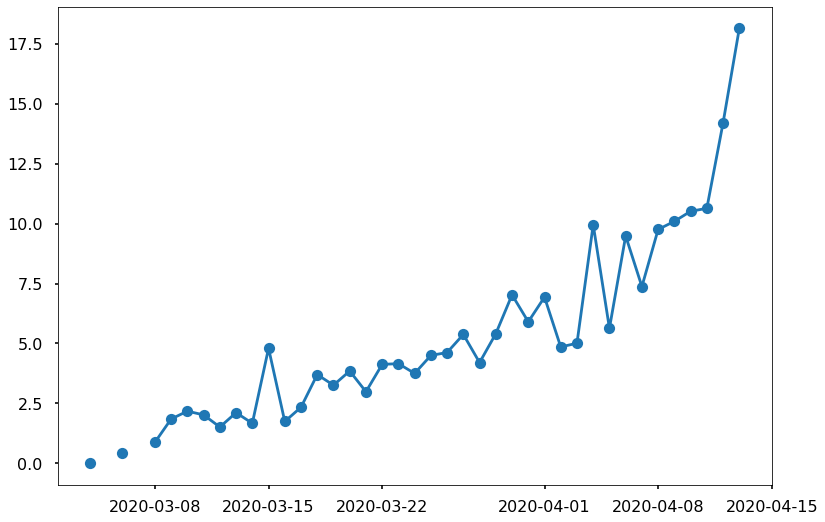

In [14]:
#data values difference and doubling time
doubling_time=[]
doubling_time_date=[]
for day, data_value, diff in zip(mdates.num2date(dates_num_extrapolate+dates_start), (pred_data*unnorm), 
                                 np.insert(np.diff(pred_data*unnorm),0,0)):
    print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time.append(np.log(2)/np.log(data_value/(data_value-diff)))
    doubling_time_date.append(day)

    
print("Last day")
print(day, np.round(data_value), np.round(diff), np.log(2)/np.log(data_value/(data_value-diff)))

print("last 7 days")
print(np.mean(doubling_time[-7:]))

plt.plot(doubling_time_date, doubling_time, linestyle="-", marker="o")


In [15]:
#subexponent prediction
for day, sub_exp_value in zip(mdates.num2date(subexp_dates_num_extrapolate+dates_start), (sub_exp_fit*unnorm)):
    print(day, sub_exp_value)

2020-01-22 00:00:00+00:00 0.0
2020-01-23 00:00:00+00:00 0.0
2020-01-24 00:00:00+00:00 0.0
2020-01-25 00:00:00+00:00 0.0
2020-01-26 00:00:00+00:00 0.0
2020-01-27 00:00:00+00:00 0.0
2020-01-28 00:00:00+00:00 0.0
2020-01-29 00:00:00+00:00 0.0
2020-01-30 00:00:00+00:00 0.0
2020-01-31 00:00:00+00:00 0.0
2020-02-01 00:00:00+00:00 0.0
2020-02-02 00:00:00+00:00 0.0
2020-02-03 00:00:00+00:00 0.0
2020-02-04 00:00:00+00:00 0.0
2020-02-05 00:00:00+00:00 0.0
2020-02-06 00:00:00+00:00 0.0
2020-02-07 00:00:00+00:00 0.0
2020-02-08 00:00:00+00:00 0.0
2020-02-09 00:00:00+00:00 0.0
2020-02-10 00:00:00+00:00 0.0
2020-02-11 00:00:00+00:00 0.0
2020-02-12 00:00:00+00:00 0.0
2020-02-13 00:00:00+00:00 0.0
2020-02-14 00:00:00+00:00 0.0
2020-02-15 00:00:00+00:00 0.0
2020-02-16 00:00:00+00:00 0.0
2020-02-17 00:00:00+00:00 0.0
2020-02-18 00:00:00+00:00 0.0
2020-02-19 00:00:00+00:00 0.0
2020-02-20 00:00:00+00:00 0.0
2020-02-21 00:00:00+00:00 0.0
2020-02-22 00:00:00+00:00 0.0
2020-02-23 00:00:00+00:00 0.0
2020-02-24

In [16]:
#general logistic prediction
for day, gen_sig_value in zip(mdates.num2date(subexp_dates_num_extrapolate+dates_start), (gen_sig_fit*unnorm)):
    print(day, gen_sig_value)

2020-01-22 00:00:00+00:00 0.0010239169517866707
2020-01-23 00:00:00+00:00 0.0012896493891209888
2020-01-24 00:00:00+00:00 0.0016243295786028435
2020-01-25 00:00:00+00:00 0.00204584011547633
2020-01-26 00:00:00+00:00 0.0025766989127281154
2020-01-27 00:00:00+00:00 0.003245259568226947
2020-01-28 00:00:00+00:00 0.004087222110057774
2020-01-29 00:00:00+00:00 0.005147534181405265
2020-01-30 00:00:00+00:00 0.006482783298827442
2020-01-31 00:00:00+00:00 0.008164206644049248
2020-02-01 00:00:00+00:00 0.010281477257879151
2020-02-02 00:00:00+00:00 0.012947466154271907
2020-02-03 00:00:00+00:00 0.016304230831983835
2020-02-04 00:00:00+00:00 0.020530544508327926
2020-02-05 00:00:00+00:00 0.025851360340956527
2020-02-06 00:00:00+00:00 0.03254970492236577
2020-02-07 00:00:00+00:00 0.04098162036612491
2020-02-08 00:00:00+00:00 0.051594930463521885
2020-02-09 00:00:00+00:00 0.06495280121601371
2020-02-10 00:00:00+00:00 0.08176330882629881
2020-02-11 00:00:00+00:00 0.10291653035171373
2020-02-12 00:0